# Mathe Macht Medikamente: die Simulation
Jitao David Zhang, Rigani Jegatheeswaran, und David Weber

*Mathe Macht Medikamente* ist ein Workshop im Rahmen von Nationen Zukunftstag von Roche am 13.11. Der Workshop ist für Kinder zwischen 5. und 7. Klasse und deren Eltern konzipiert. Mehr Information über den Workshop ist [hier in einer Google Dokument](https://docs.google.com/document/d/1UBZIqVgjBpYKxbMi2KZX1lr_SdCBscWbLFOQXIVed80/edit?usp=sharing) zu finden.

Der Workshop findet zweimal statt: einmal am Morgen und einmal am Nachmittag. Die Daten sind nur für jeweilige Session gespeichert, und danach werden gelöscht.

Für dieses Event planen wir maximum 30 Teams.

## Vorbereitungen

Jedes Kind/Elternteil paar bekommt ein Papier, darauf steht sechs QR codes und relevante Informationen:

* Tech Check: Team eingeben
* Set 1 (Körpergrösse)
* Set 2 (Umfang des Raums)
* Set 3: Klinische Studie #1
* Set 4: Klinische Studie #2
* Feedback

In [1]:
import random
import pandas as pd
import numpy as np
import itables
import matplotlib
import seaborn as sns
import mplcursors as mc

%matplotlib widget

from itables import show
import matplotlib.pyplot as plt

matplotlib_font = {'size': 22}
matplotlib.rc('font', **matplotlib_font)
matplotlib.rcParams['figure.figsize'] = [8, 8]

itables.options.allow_html = True
itables.options.style = "table-layout: auto; width: auto; font-size: huge;"

n_teilnahme = 25
random.seed(1887)
np.random.seed(1887)

umfang_ground_truth = 25

In [2]:
## Teams: ChatGPT, https://chatgpt.com/share/e/68f8f919-f328-8009-adbf-f3c76574926e
with open('data/animals.txt', 'r') as tn:
    all_team_namen_str = filter(bool, tn.read().split("\n")) ## the filter/book trick removes ANY empty string
    all_team_namen = dict(item.split(":") for item in all_team_namen_str)
## Kindervornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/vornamen-neugeborene.assetdetail.540003.html
with open('data/kinder_vornamen.txt', 'r') as kf:
    kinder_vornamen = list(filter(bool, kf.read().splitlines()))
## Elternvornamen: https://www.bfs.admin.ch/bfs/de/home/statistiken/bevoelkerung/geburten-todesfaelle/namen-schweiz.html, Jahrgang 1984
with open('data/eltern_vornamen.txt', 'r') as ef:
    eltern_vornamen = list(filter(bool, ef.read().splitlines()))

In [3]:
all_team_namen_de = list(all_team_namen.keys())
all_team_namen_en = list(all_team_namen.values())

In [4]:
team_namen_de = random.sample(all_team_namen_de, n_teilnahme)
team_namen_en = [all_team_namen[k] for k in team_namen_de]
team_kind_vornamen = random.choices(kinder_vornamen, k=n_teilnahme) ## choices sample WITH replacement, samples WITHOUT replacement
team_eltern_vornamen = random.choices(eltern_vornamen, k=n_teilnahme)

In [5]:
team_df = pd.DataFrame({'index': range(1, len(team_namen_de) + 1),
                        'Team_de':team_namen_de,
                        'Team_en':team_namen_en,
                        'Eltern': team_eltern_vornamen,
                        'Kind': team_kind_vornamen})
team_df.set_index("index");

## Tech Check: Team und Namen eingeben

Jedes Team (Eltern + Kind) scannt den QR code (jedes Team, i.e. auf jedem Papier, hat ein eigenes QR Code). Der Server fragt nach Vornamen von dem Elternteil und dem Kind.

Ergebnisse:

* Eine Tabelle mit alle Teamnamen, die benutzt werden, und der Vornamen von Kindern und Eltern. Die Tabelle soll spaltenweise sortierbar sein.
* Eine Tabelle mit allen einzigartigen Vornamen, und deren Frequenz untern Eltern, Kindern, und beiden.

**Wichtig**: Jederzeit müssen wir in der Lage sein, alle gesammelten und abgeleiteten Daten (Teams, Vornamen, Körpergrössen, Umhang bzw. Unterschied zum richtigen Wert, usw.) in einer Tabelle zeigen können, um Konzept wie Median zu erklären. Es könnte so aussehen:  

In [6]:
show(team_df, paging=False)

Loading ITables v2.5.2 from the internet... (need help?)


In [7]:
team_all_namen = team_eltern_vornamen + team_kind_vornamen
team_all_namen_frequenz = pd.Series(team_all_namen).value_counts().reset_index()
team_all_namen_frequenz.columns = ['Name', 'Frequenz']
show(team_all_namen_frequenz)

Loading ITables v2.5.2 from the internet... (need help?)


## Spiel 1: Körpergrössen

Eingaben:

* Teamname
* Grösse von dem Elternteil, in centimeter (validation: nummer, und centimeter, NICHT meter, i.e. >10)
* Grösse von dem Kind, in centimeter

In [8]:
np.random.seed(1887)
eltern_groesse, kind_groesse = np.around(np.random.multivariate_normal(mean=[180, 120], cov=[[15, 7], [7, 15]], size=n_teilnahme).T, 1)

In [9]:
team_df["Eltern_groesse"] = eltern_groesse
team_df["Kind_groesse"] = kind_groesse

[Text(0.5, 0, 'Grösse vom Eltern [centimeter]')]

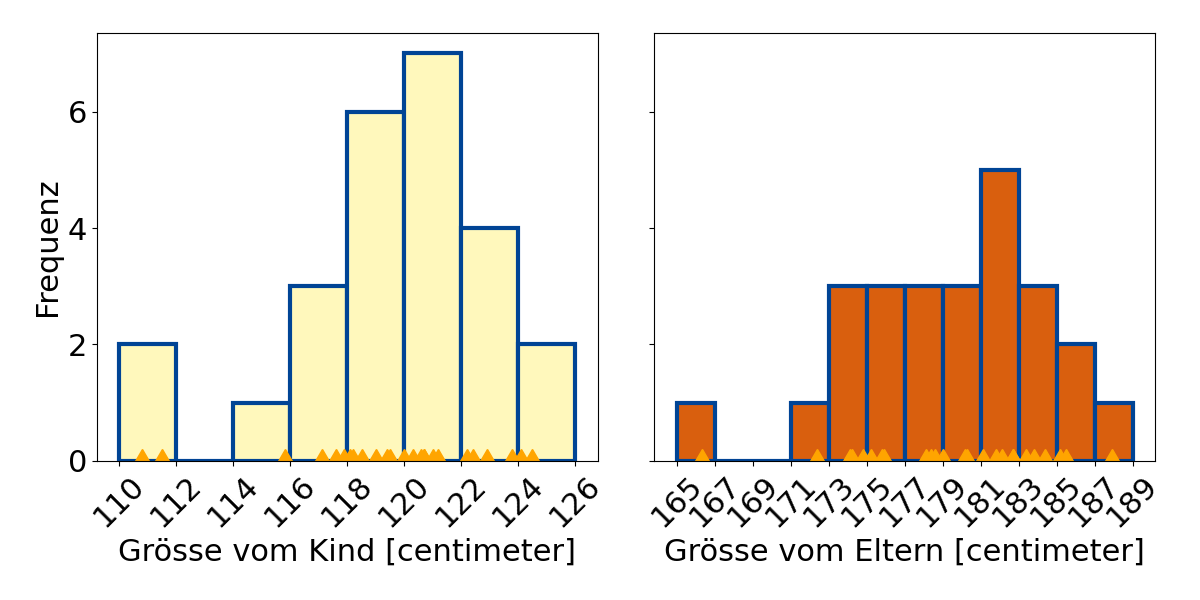

In [10]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, 
                        figsize=(12, 6))

def groesse_bins(values, bin_size=2):
    min_val = int(np.round(np.min(values)))
    max_val = int(np.round(np.max(values)))
    res = np.arange(min_val-1, max_val+bin_size+1, bin_size) ## +bin_size+1 makes sure that data in the the last bin is shown
    return(res)

def plot_groesse(values, ax, style, bin_size=2):
    value_bins = groesse_bins(values, bin_size=bin_size)
    ax.hist(values, bins=value_bins, width=bin_size, **style)
    ax.set(xticks=value_bins)
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.plot(values, 0*values, 'd', color="orange", markersize=12)
    return(ax)

axs[0] = plot_groesse(kind_groesse, axs[0],
                      style={'facecolor': '#FFF8BC', 'edgecolor': '#004495', 'linewidth': 3})
axs[0].set(xlabel="Grösse vom Kind [centimeter]", ylabel="Frequenz")
axs[1] = plot_groesse(eltern_groesse, axs[1],
                      style={'facecolor': '#D95F0E', 'edgecolor': '#004495', 'linewidth': 3})
axs[1].set(xlabel="Grösse vom Eltern [centimeter]")
## plt.close(fig)

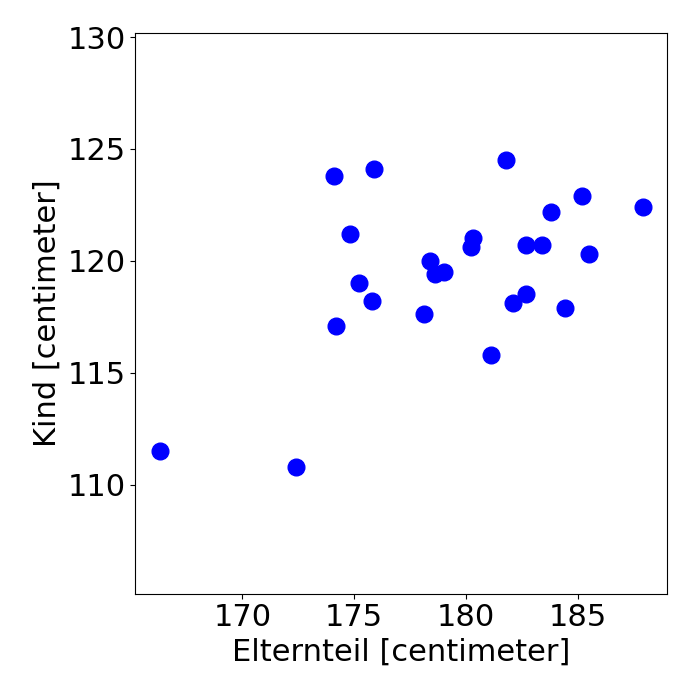

In [11]:
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(7, 7))
ax.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=12,
         linestyle="none", color="blue", marker="o")
cursor = mc.cursor(hover=mc.HoverMode.Transient)
cursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_de"][sel.index] + "\n" +
                                              team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_groesse"][sel.index]) + "cm\n" +
                                              team_df["Kind"][sel.index] + ": " + str(team_df["Kind_groesse"][sel.index]) + "cm"))
ax.set_xlabel("Elternteil [centimeter]")
ax.set_ylabel("Kind [centimeter]")
ax.axis('equal')
plt.show()

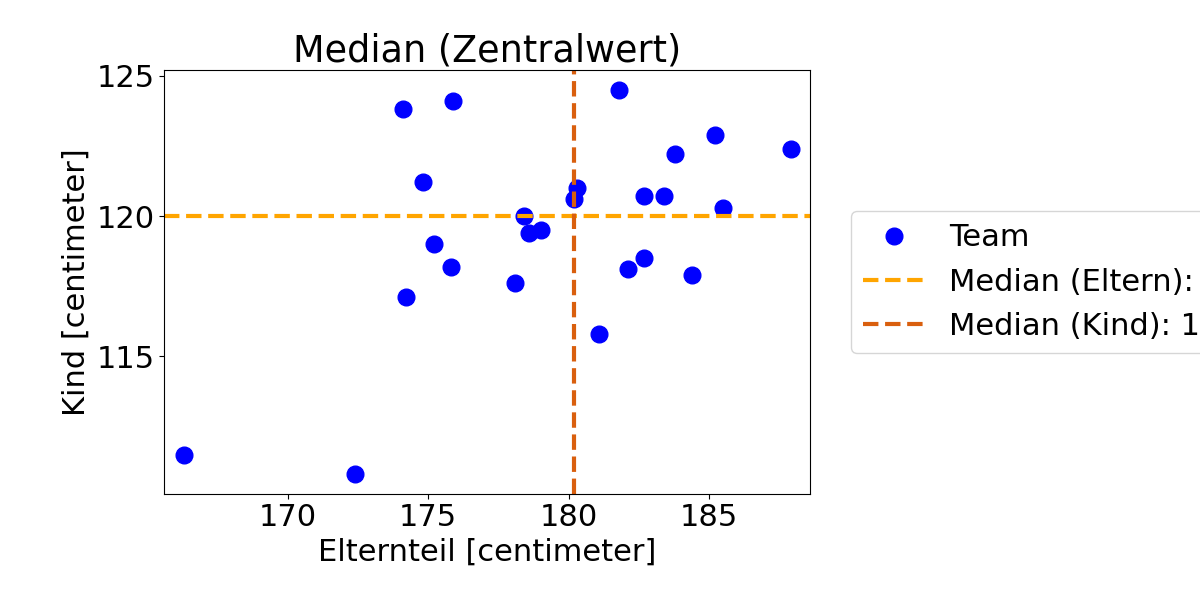

In [12]:
eltern_med = np.median(eltern_groesse)
kind_med = np.median(kind_groesse)
med_dict = {'color': 'darkred',
            'size': 18,
            'weight': 'bold'}

fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(12, 6))
ax.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=12, label="Team", 
         linestyle="none", color="blue", marker="o")
ax.set_xlabel("Elternteil [centimeter]")
ax.set_ylabel("Kind [centimeter]")
ax.axis('equal')
ax.axhline(kind_med, c="orange", ls="--", linewidth=3,
           label="Median (Eltern): " + str(eltern_med) + "cm")
ax.axvline(eltern_med, c="#D95F0E", ls="--", linewidth=3,
           label="Median (Kind): " + str(kind_med) + "cm", )
ax.set_title("Median (Zentralwert)")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
##plt.close(fig)

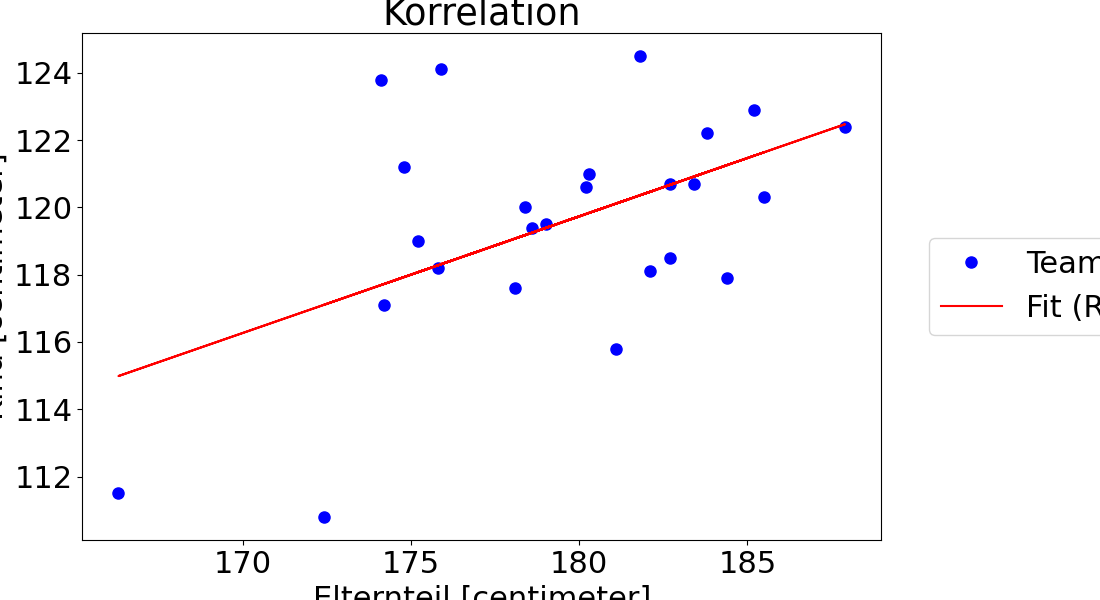

In [13]:
coef, coef_var = np.polyfit(eltern_groesse, kind_groesse, 1, cov=True)
poly1d_fn = np.poly1d(coef)

fig = plt.figure(figsize=(11, 6), tight_layout=True)
ax = plt.subplot(111)
ax.plot("Eltern_groesse", "Kind_groesse", data=team_df, 
         markersize=8, label="Team",
         linestyle="none", color="blue", marker="o")
ax.axis('equal')
ax.set_aspect('equal', 'box')
ax.plot(eltern_groesse, poly1d_fn(eltern_groesse), 'r',
       label="Fit (Regression)")
## ax.plot(eltern_groesse, np.polyval(coef, eltern_groesse), "r")
ax.set_xlabel("Elternteil [centimeter]")
ax.set_ylabel("Kind [centimeter]")
ax.set_title("Korrelation")

# Shrink current axis by 30%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
## plt.close(fig)

## Spiel 2: Umfang des Raums

Mit einer Markierung auf dem Boden zeigen wir den Eltern und Kindern, wie lang einen Meter ist. Dann haben die Eltern und Kinder 5 Minuten Zeit, dem Unfang des Raums zu schätzen. Dabei dürfen Eltern miteinadner austauschen, und Kinder dürfen miteinander austauschen, aber kein Austasch zwischen Eltern und Kinder sind erlaubt.

Bei der Eingabe geben ein Elternteil und das Kind von jedem Team jeweils einen Schätzungswert. Das Elternteil und das Kind, die nähst an den richtigen Wert kommen, gewinnen.

In [14]:
np.random.seed(1887)
eltern_umfang_werte = np.around(np.random.normal(umfang_ground_truth * 1.2, scale=5, size=len(team_eltern_vornamen)), 2)
kind_umfang_werte = np.around(np.random.normal(umfang_ground_truth * 0.9, scale=8, size=len(team_kind_vornamen)),1 )
team_df['Eltern_Umfang'] = eltern_umfang_werte
team_df['Kind_Umfang'] = kind_umfang_werte
show(team_df)

Loading ITables v2.5.2 from the internet... (need help?)


In [15]:
all_umfang_werte = [eltern_umfang_werte] + [kind_umfang_werte]
all_umfang_med = np.median(all_umfang_werte)

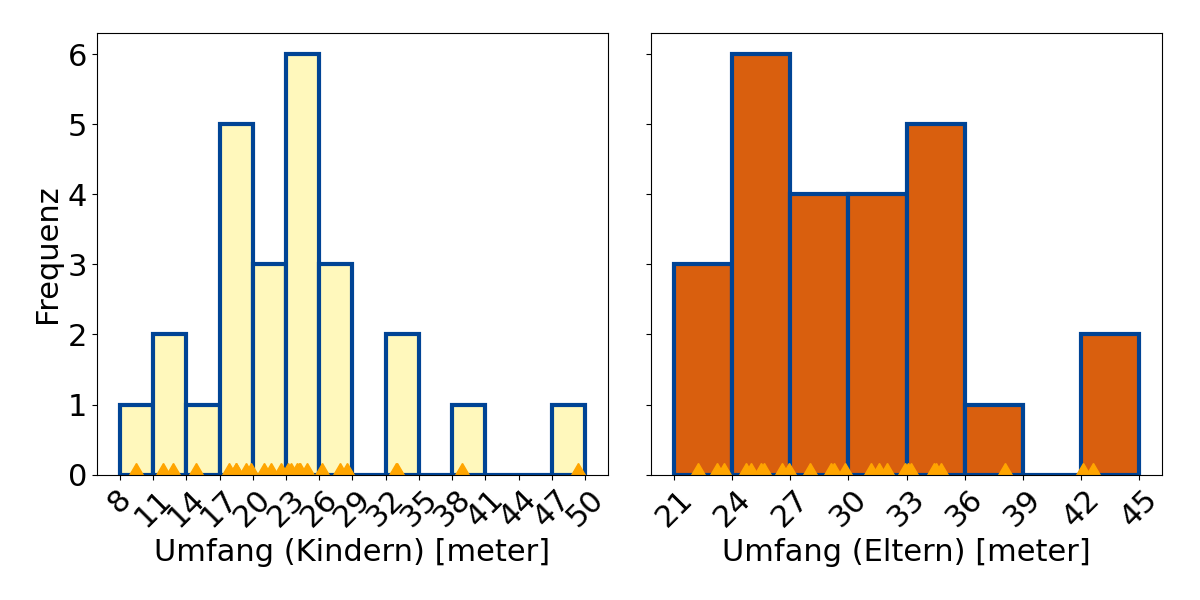

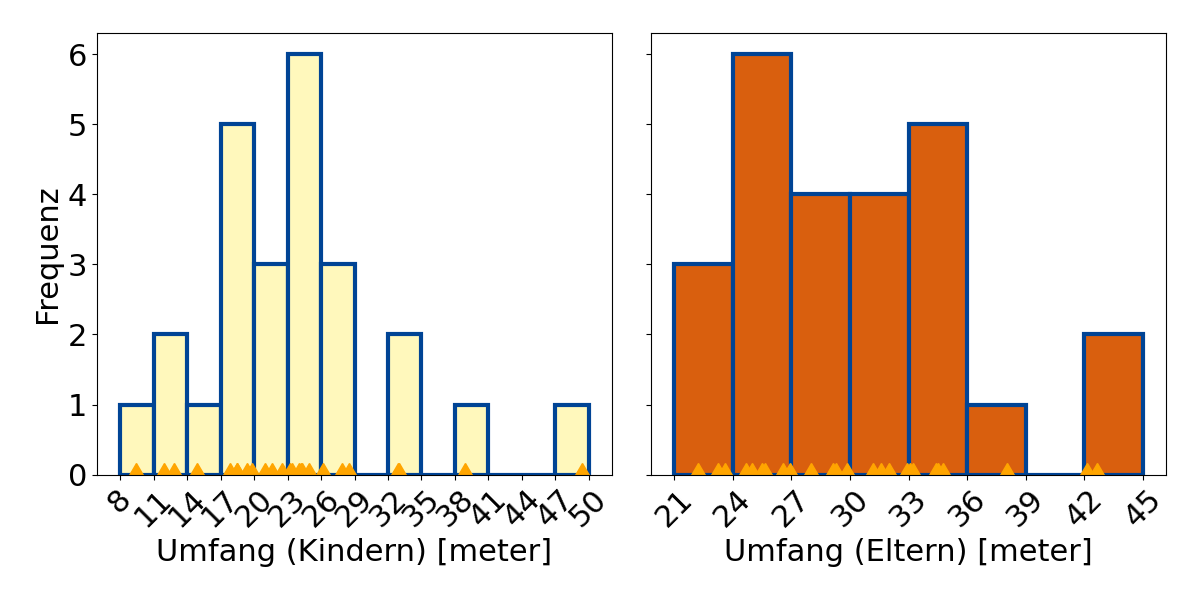

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, 
                        figsize=(12, 6))

axs[0] = plot_groesse(team_df['Kind_Umfang'], axs[0],
                      style={'facecolor': '#FFF8BC', 'edgecolor': '#004495', 'linewidth': 3},
                     bin_size=3)
axs[0].set(xlabel="Umfang (Kindern) [meter]", ylabel="Frequenz")
axs[1] = plot_groesse(team_df['Eltern_Umfang'], axs[1],
                      style={'facecolor': '#D95F0E', 'edgecolor': '#004495', 'linewidth': 3},
                     bin_size=3)
axs[1].set(xlabel="Umfang (Eltern) [meter]")
fig.show()
## plt.close(fig)

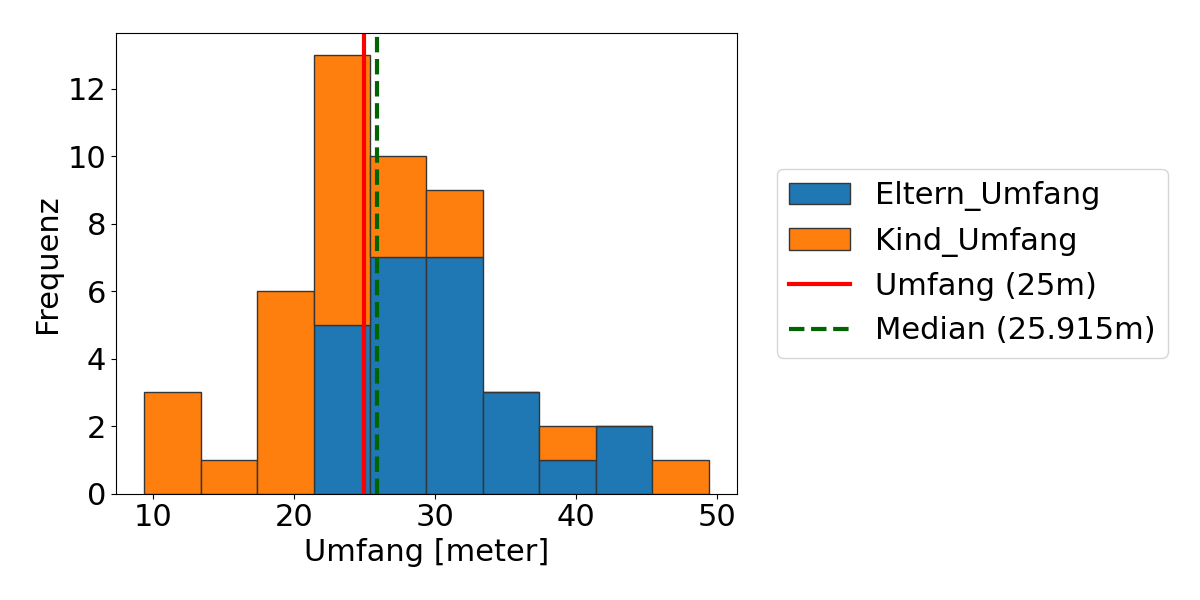

In [17]:
med_dict = {'color': 'darkred',
            'size': 18,
            'weight': 'bold'}
ground_truth_dict = {'color': 'darkgreen',
            'size': 18,
            'weight': 'bold'}

fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
hist = team_df[['Eltern_Umfang', 'Kind_Umfang']].plot.hist(stacked=True, 
                                                    ec='#363636', ax=ax,
                                                    bins=10)
ugt_line = hist.axvline(umfang_ground_truth, color="red", ls="-", linewidth=3,
                        label="Umfang (" + str(umfang_ground_truth) + "m)")
um_line = hist.axvline(all_umfang_med, color="darkgreen", ls="--", linewidth=3, 
                       label="Median (" + str(all_umfang_med) + "m)")
hist.set_xlabel("Umfang [meter]")
hist.set_ylabel("Frequenz")
hist_handles, hist_labels = hist.get_legend_handles_labels()
hist.legend(handles=hist_handles, 
            labels=hist_labels, bbox_to_anchor=(1.04, 0.5), loc="center left")
plt.show()
## plt.close(fig)

In [18]:
team_df["Eltern_Umfang_Delta"] = team_df["Eltern_Umfang"] - umfang_ground_truth
team_df["Kind_Umfang_Delta"] = team_df["Kind_Umfang"] - umfang_ground_truth

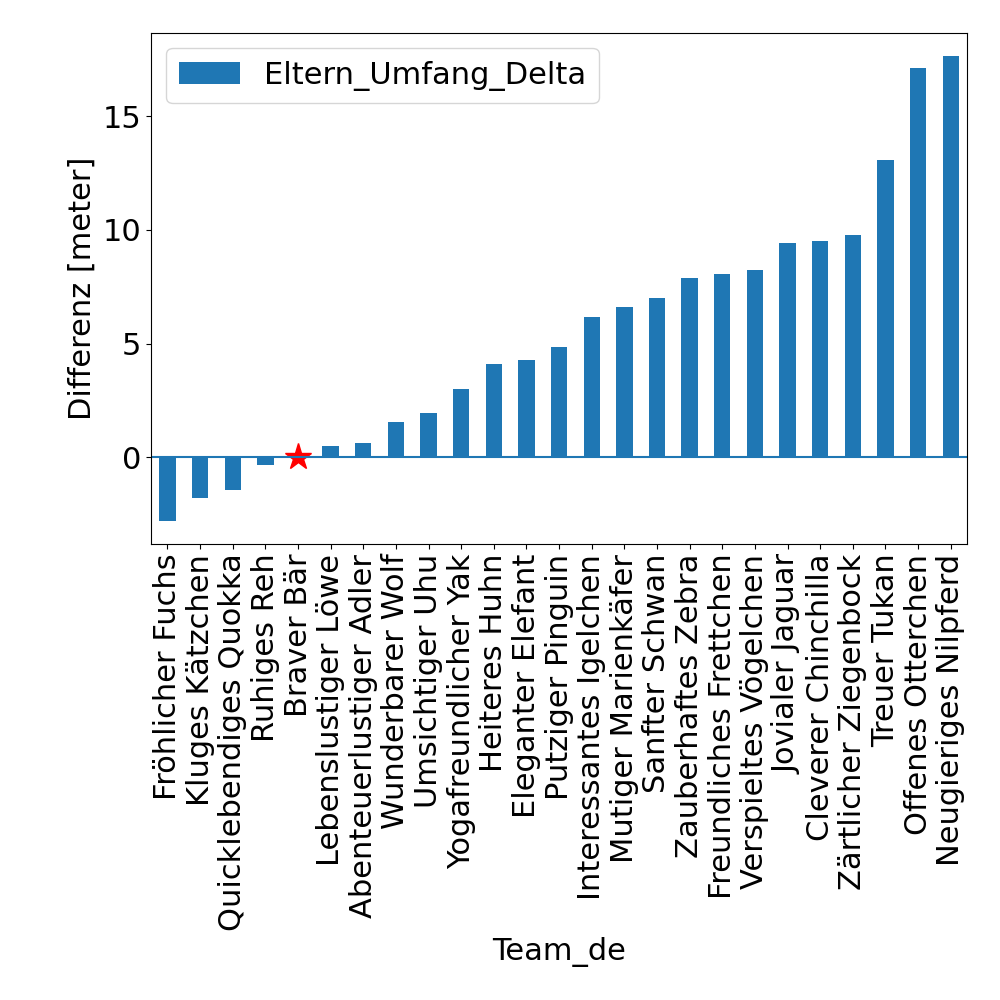

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)
team_df_eltern_umfang_sorted = team_df.sort_values("Eltern_Umfang_Delta")
team_df_eltern_umfang_sorted.plot.bar(x="Team_de", y="Eltern_Umfang_Delta",
                                     ax=ax)
eltern_gewinner = np.argmin(abs(team_df_eltern_umfang_sorted["Eltern_Umfang_Delta"]))
ax.plot(eltern_gewinner, 0, color="red", marker="*", markersize=20)
ax.set_ylabel("Differenz [meter]")
ax.axhline(0);
## plt.close(fig)

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), tight_layout=True)
team_df_kind_umfang_sorted = team_df.sort_values("Kind_Umfang_Delta")
team_df_kind_umfang_sorted.plot.bar(x="Team_de", y="Kind_Umfang_Delta",
                                     ax=ax)
kind_gewinner = np.argmin(abs(team_df_kind_umfang_sorted["Kind_Umfang_Delta"]))
ax.plot(kind_gewinner, 0, color="red", marker="*", markersize=20)
ax.set_ylabel("Differenz [meter]")
ax.axhline(0);
##plt.close(fig)

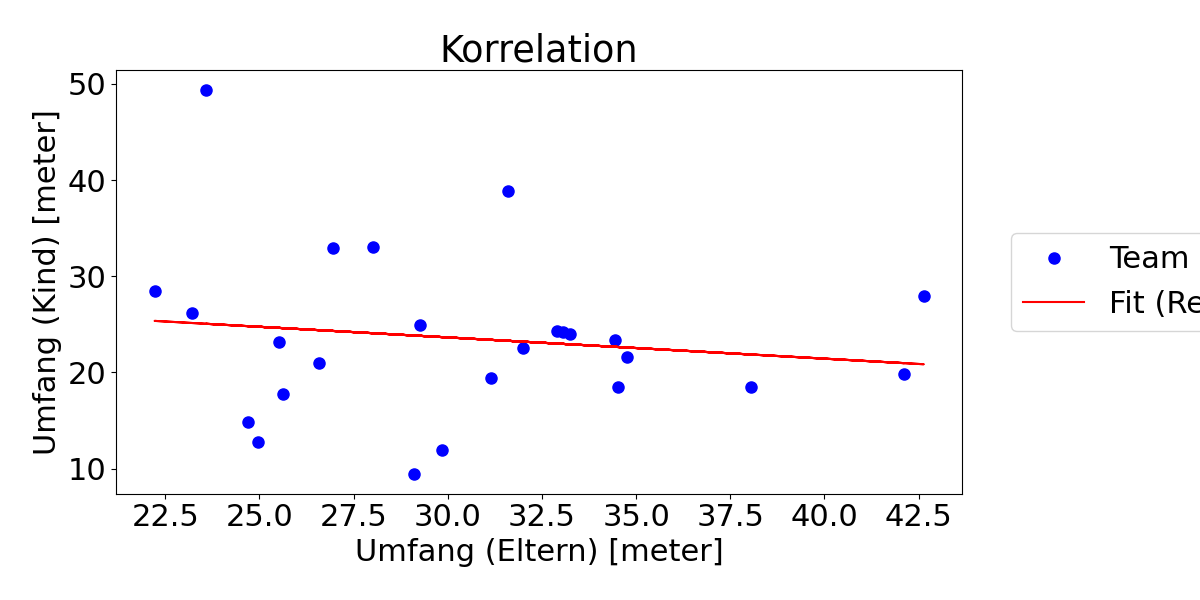

In [22]:
umfang_coef = np.polyfit(team_df['Eltern_Umfang'],
                         team_df['Kind_Umfang'], 1)
umfang_poly1d_fn = np.poly1d(umfang_coef)

fig, ax = plt.subplots(1, 1, figsize=(12, 6), tight_layout=True)
ax.plot("Eltern_Umfang", "Kind_Umfang", data=team_df, 
         markersize=8, label="Team",
         linestyle="none", color="blue", marker="o")
cursor = mc.cursor(hover=mc.HoverMode.Transient)
cursor.connect("add", lambda sel: sel.annotation.set_text(team_df["Team_de"][sel.index] + "\n" +
                                              team_df["Eltern"][sel.index] + ": " + str(team_df["Eltern_Umfang"][sel.index]) + "m\n" +
                                              team_df["Kind"][sel.index] + ": " + str(team_df["Kind_Umfang"][sel.index]) + "m"))
ax.plot(team_df['Eltern_Umfang'],
        umfang_poly1d_fn(team_df['Eltern_Umfang']), 'r',
       label="Fit (Regression)")
ax.set_xlabel("Umfang (Eltern) [meter]")
ax.set_ylabel("Umfang (Kind) [meter]")
ax.set_title("Korrelation")

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")
fig.show()
##plt.close(fig)